# imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os, time
sys.path.append('/mnt/home/cmodi/.local/lib/python3.8/site-packages/')

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import sbi
import torch
import wandb
from wandb import Api
import zeus
import emcee

from arviz import rhat, ess, autocorr

In [4]:
from sbi.inference import SNLE_A
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn


In [5]:
sys.path.append('../src/')

import loader_pk, loader_hybrid
import sbitools, sbiplots
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
testidx = np.load('../data/testidx_p0-0.15-0.45_p4-0.65-0.95.npy')
params = sbitools.quijote_params()[0]

In [7]:
bounds = [params.min(axis=0), params.max(axis=0)]
goodids = []
for pid in testidx:
    p = params[pid]
    good = True
    for j in range(5):
        r = bounds[1][j] - bounds[0][j] 
        if (bounds[0][j] + 0.25*r < p[j] < bounds[1][j] - 0.25*r):
            pass
        else:
            good = False
    if good:
        print(pid, p)
        goodids.append(pid)

865 [0.3199  0.04035 0.7235  1.0251  0.8329 ]
663 [0.3223  0.04625 0.7015  0.9607  0.8311 ]
1964 [0.3157  0.05723 0.7491  0.9563  0.8091 ]
121 [0.2541  0.04943 0.7997  0.9459  0.8819 ]
696 [0.2057  0.05959 0.7193  1.0443  0.8343 ]
1539 [0.3149  0.05077 0.7161  0.9655  0.8847 ]
1329 [0.3403  0.05119 0.7409  0.9357  0.8915 ]
909 [0.3349  0.04321 0.7655  1.0095  0.7535 ]
964 [0.3151  0.04039 0.6893  0.9023  0.7923 ]


# rankplots

In [8]:
# path = '/mnt/ceph/users/cmodi/HySBI/matter/samples/'
# runs = [f'{path}/PT/kmax0.15/LH%d.npy',
#         f'{path}/PT/kmax0.1/LH%d.npy',
#         f'{path}/PT/kmax0.2/LH%d.npy',
#         f'{path}/snle_wronglp//emcee_chains/kmax0.5-kmin0.001-logit-standardize/ens5//LH%d.npy',
#         f'{path}/snle/emcee_chains/kmax0.15-kmin0.001-logit-standardize/ens5//LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.5-kmin0.15-logit-standardize/ens5/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid_independent/emcee_chains/kmax0.5-kmin0.15-logit-nsubs1-splits2-standardize/ens5//LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits2-standardize-standardize_cond/ens10//LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy', 
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-logit-logit_cond-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-logit-logit_cond-nsubs4-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-logit-logit_cond-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens5//LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits4-standardize-standardize_cond/ens5/LH%d.npy',
#         # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs32-splits4-standardize-standardize_cond/ens5/LH%d.npy',
#         # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.1-meanf-nsubs8-splits2-standardize-standardize_cond/ens5/LH%d.npy',
#         # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-sym/ens10/LH%d.npy',
#         f'{path}/hybrid2_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2_small_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
#         f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/ens10/LH%d.npy',
#         f'{path}/hybrid2_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/ens10/LH%d.npy',
#        ]

# run = runs[-1]
# print(run)
# nsims = 300
# ss = []
# allsamples = []
# thin = 50 
# acs = []
# for i in range(nsims):
#     isim = testidx[i]
#     if True : #(0.15 < params[isim, 0] < 0.45) & (0.65 < params[isim, 4] < 0.95) :
#         try:
#             # samples = (np.load(run%isim))
#             samples = clean_chains(np.load(run%isim))
#             allsamples.append(samples)
#         except:
#             continue
#         mu, std = samples.mean(axis=(0, 1)), samples.std(axis=(0, 1))
        
#         # acs.append([np.array(list(map(iat_imse, (samples[:, :, idim].T)))).astype(int).max() for idim in range(5)])
#         # ranks = [(samples[..., j] < params[isim, j]).sum() for j in range(5)]
#         ranks = [(samples[::thin, :, j] < params[isim, j]).sum() for j in range(5)]
        
#         ss.append(np.stack([params[isim], mu[:5], std[:5], ranks]).T)
# ss = np.array(ss)
# acs = np.array(acs)
# # allsamples = np.array(allsamples)
# print(ss.shape)    

In [9]:
# fig, ax = plt.subplots(1, 5, figsize=(18, 4))

# for idim in range(5):
#     ax[idim].errorbar(ss[:, idim, 0], ss[:, idim, 1], ss[:, idim, 2], fmt='.')
#     ax[idim].plot([ss[:, idim, 0].min(), ss[:, idim, 0].max()], [ss[:, idim, 0].min(), ss[:, idim, 0].max()], 'k')
#     ax[idim].grid(which='both')
# plt.show()

# nbins = 10 
# h = ss.shape[0]/nbins

# fig, ax = plt.subplots(1, 5, figsize=(18, 4))

# for idim in range(5):
#     ax[idim].hist(ss[:, idim, 3], bins=nbins)
#     ax[idim].axhline(h - h**.5, color='k', ls='--')
#     ax[idim].axhline(h + h**.5, color='k', ls='--')
#     ax[idim].grid(which='both')

# plt.show()

# without conditioning

In [10]:
import loader_hybrid, loader_pk, loader_pk_splits
base_path = "/mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid/"
data_path = '..//data/'
# isim = lh

In [19]:

# # cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
# cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/"
# # cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
# cfg_path = f"{base_path}/{cfgfolder}/"

# print("\nloading sweep")
# sweepdict = sbitools.setup_sweepdict(cfg_path)
# cfg = sweepdict['cfg']
   
# # ksmall_sub, features, params = loader_hybrid.lh_features(cfg)
# ksmall, kcond, features, params = loader_hybrid.loader(cfg, return_k=True)
# print("features shape : ", features.shape)
# features = features[:, 0, :]
# trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=cfg.logit)
# trainy = params[:, 0, :5].copy()


In [11]:
# cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/"
# cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
cfg_path = f"{base_path}/{cfgfolder}/"

print("\nloading sweep")
sweepdict = sbitools.setup_sweepdict(cfg_path)
cfg = sweepdict['cfg']



loading sweep
In directory /mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid//kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp//
Sweep found : f9de89jo


In [13]:
cfg.style = '-deconv'

## Set-up data

In [14]:
# ksmall_sub, features, params = loader_hybrid.lh_features(cfg)
ksmall, kcond, pk_small_deconv, params_cond = loader_hybrid.loader(cfg, return_k=True)
print("features shape : ", pk_small_deconv.shape)
print("params_cond shape : ", params_cond.shape)
pk_small_deconv = pk_small_deconv[:, 0, :]
trainx_small, scaler = sbitools.standardize(pk_small_deconv, secondary=None, log_transform=cfg.logit)
trainy = params_cond[:, 0, :5].copy()


Loaded power spectrum data with shape :  (2000, 1, 63)
pk shape after k-cuts :  (2000, 1, 28)
Loaded power spectrum conditioning data with shape :  (2000, 127, 2)
pk shape after k-cuts :  (2000, 23)
features shape :  (2000, 1, 28)
params_cond shape :  (2000, 1, 28)


In [16]:
ksmall;

In [19]:
## Set up true small scale data
ksmall_true, pk_small_true, _ = loader_pk.lh_features(cfg, dk=2)
idx = (ksmall_true > cfg.ksplit) & (ksmall_true < cfg.kmax)
ksmall_true, pk_small_true = ksmall_true[idx], pk_small_true[:, idx]

pk_small_true_normalized = sbitools.standardize(pk_small_true.copy(), scaler=scaler, log_transform=cfg.logit)[0]


Loaded power spectrum data with shape :  (2000, 63)
pk shape after k-cuts :  (2000, 39)


In [29]:
# i = 6
# plt.plot(ksmall, pk_small_deconv[i]/pk_small_true[i])

In [21]:
# np.save('./tmp-dk2/pk_small_deconv', pk_small_deconv)
# np.save('./tmp-dk2/trainx_small', trainx_small)
# np.save('./tmp-dk2/trainy', trainy)
# np.save('./tmp-dk2/pk_small_true_normalized', pk_small_true_normalized)


## SNPE

In [22]:
prior = sbitools.sbi_prior(trainy.copy(), offset=0.2)
posterior_snpe, inference_snpe, summary_snpe = sbitools.sbi(trainx_small, trainy, prior, \
                                            summarize=True,
                                            verbose=True, 
                                             nlayers=8, alg='snpe')

Training a new NF
With algorithm SNPE
 Neural network successfully converged after 252 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 252
        Best validation performance: 12.5641
        -------------------------
        


In [23]:
nsims, nsamples = 100, 1000
samples_snpe = np.zeros([nsims, nsamples, trainy.shape[1]])
samples_snpe_truedata = np.zeros([nsims, nsamples, trainy.shape[1]])
for j in range(100):
    x = trainx_small[j].copy()
    samples_snpe[j] = posterior_snpe.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()
    x = pk_small_true_normalized[j].copy()
    samples_snpe_truedata[j] = posterior_snpe.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()


<ErrorbarContainer object of 3 artists>

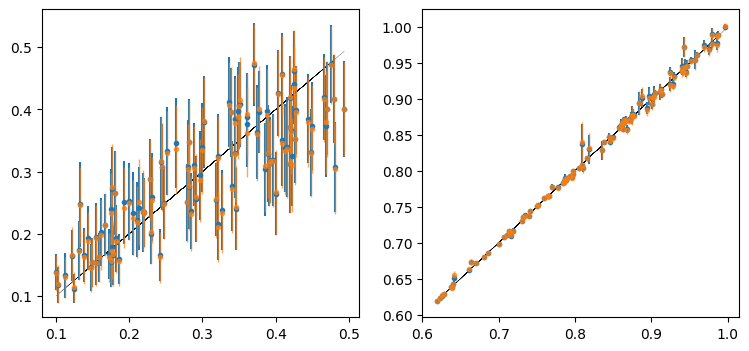

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

j = 0
ax[0].plot(trainy[:nsims, j], trainy[:nsims, j], 'k', lw=0.1)
ax[0].errorbar(trainy[:nsims, j], samples_snpe.mean(axis=1)[:, j], samples_snpe.std(axis=1)[:, j], fmt='.')
ax[0].errorbar(trainy[:nsims, j], samples_snpe_truedata.mean(axis=1)[:, j], samples_snpe_truedata.std(axis=1)[:, j], fmt='.', elinewidth=1, alpha=0.7)

j = 4
ax[1].plot(trainy[:nsims, j], trainy[:nsims, j], 'k', lw=0.1)
ax[1].errorbar(trainy[:nsims, j], samples_snpe.mean(axis=1)[:, j], samples_snpe.std(axis=1)[:, j], fmt='.')
ax[1].errorbar(trainy[:nsims, j], samples_snpe_truedata.mean(axis=1)[:, j], samples_snpe_truedata.std(axis=1)[:, j], fmt='.', elinewidth=1, alpha=0.7)


## SNLE

In [30]:
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun, device='cpu')
inference.append_simulations(x= torch.from_numpy(trainx_small.astype('float32')), 
                            theta= torch.from_numpy(trainy.astype('float32')))

density_estimator = inference.train(training_batch_size=16,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference.build_posterior(density_estimator)

sbitools.save_posterior(posterior_nle, './tmp-dk2/snle_small/')
sbitools.save_inference(inference,  './tmp-dk2/snle_small/')

 Neural network successfully converged after 122 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 122
        Best validation performance: 68.0009
        -------------------------
        


/mnt/home/cmodi/.local/lib/python3.8/site-packages/sbi/inference/base.py:449: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  warn(


In [97]:
# # isim = np.random.randint(nsims)
# # print(isim)
# isim = 0 
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# j = 0
# ax[0].hist(samples[isim, :, j], alpha=0.5, bins=30, density=True)
# ax[0].hist(samples2[isim, :, j], alpha=0.5, bins=30, density=True);
# ax[0].hist(samples_nle[:, j], alpha=0.5, bins=30, density=True);
# ax[0].hist(samples_nle2[ :, j], alpha=0.5, bins=30, density=True);
# ax[0].hist(ss[..., j].flatten(), alpha=0.5, bins=30, density=True)
# ax[0].axvline(trainy[isim, j], color='k')

# j = 4
# ax[1].hist(samples[isim, :, j], alpha=0.5, bins=30, density=True)
# ax[1].hist(samples2[isim, :, j], alpha=0.5, bins=30, density=True);
# ax[1].axvline(trainy[isim, j], color='k')
# ax[1].hist(samples_nle[:, j], alpha=0.5, bins=30, density=True);
# ax[1].hist(samples_nle2[:, j], alpha=0.5, bins=30, density=True);
# ax[1].hist(ss[..., j].flatten(), alpha=0.5, bins=30, density=True)

# ax[2].plot(ksmalld, features[isim]/pk_smalld[isim])
# # ax[2].plot(ksmalld, features2[isim]/pk_smalld[isim])
# ax[2].axhline(1, color='k')
# for axis in ax:
#     axis.grid(which='both')
# plt.show()

# SNLE with conditioning

In [31]:
trainy_cond = params_cond[:, 0, :].copy()
np.save('./tmp-dk2/trainy_cond', trainy_cond)


In [32]:
trainx_small.shape, trainy_cond.shape

((2000, 28), (2000, 28))

In [33]:
density_estimator_build_fun_cond = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference_cond = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun_cond, device='cpu')
inference_cond.append_simulations(x= torch.from_numpy(trainx_small.astype('float32')), 
                            theta= torch.from_numpy(trainy_cond.astype('float32')))

density_estimator_cond = inference_cond.train(training_batch_size=16,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle_cond = inference_cond.build_posterior(density_estimator_cond)

sbitools.save_posterior(posterior_nle_cond, './tmp-dk2/snle_small_cond/')
sbitools.save_inference(inference_cond,  './tmp-dk2/snle_small_cond/')

 Neural network successfully converged after 84 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 84
        Best validation performance: 67.0654
        -------------------------
        


# load snle samples

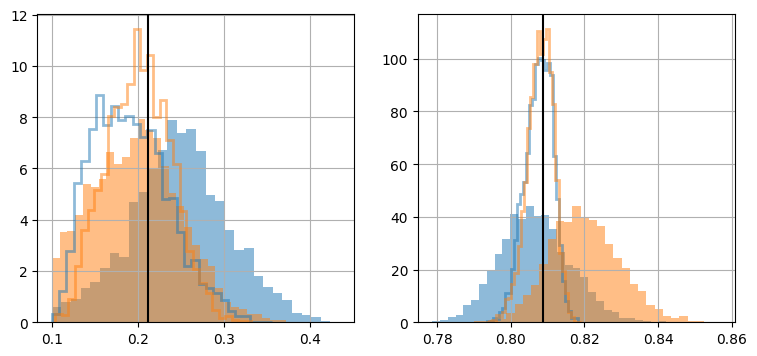

In [46]:
isim = 45

samples_nle_true = np.load(f'./tmp-dk2/snle_small/LH{isim}_truedata.npy')
samples_nle = np.load(f'./tmp-dk2/snle_small/LH{isim}.npy')

samples_nle_cond_true = np.load(f'./tmp-dk2/snle_small_cond/LH{isim}_truedata.npy')
samples_nle_cond = np.load(f'./tmp-dk2/snle_small_cond/LH{isim}.npy')

# isim = np.random.randint(nsims)
# print(isim)
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

j = 0
ax[0].hist(samples_nle[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C0', histtype='step', lw=2)
ax[0].hist(samples_nle_true[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C1', histtype='step', lw=2)

ax[0].hist(samples_nle_cond[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C0')
ax[0].hist(samples_nle_cond_true[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C1')
ax[0].axvline(trainy[isim, j], color='k')

j = 4
ax[1].hist(samples_nle[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C0', histtype='step', lw=2)
ax[1].hist(samples_nle_true[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C1', histtype='step', lw=2)

ax[1].hist(samples_nle_cond[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C0')
ax[1].hist(samples_nle_cond_true[..., j].flatten(), alpha=0.5, bins=30, density=True, color='C1')
ax[1].axvline(trainy[isim, j], color='k')

for axis in ax:
    axis.grid(which='both')
plt.show()

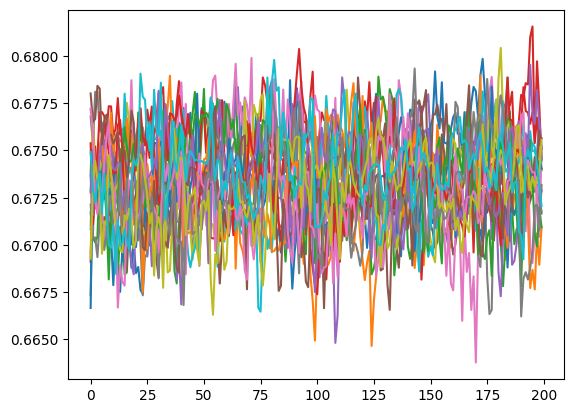

In [36]:
plt.plot(samples_nle_true[..., -1])

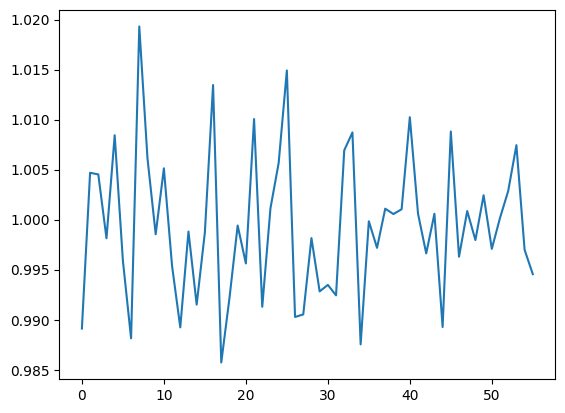

In [115]:
plt.plot(pk_small_deconv[isim]/ pk_small_true[isim])

